In [79]:
import math
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import multivariate_normal


import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.colors import from_levels_and_colors
import seaborn as sns
import os
from sklearn.impute import KNNImputer 
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append('../../Code')
from CustomTransformers import ColOutlierRemover

In [80]:
df = pd.read_csv("../../datasets/bsas_realstate_on_sale_properati_dataset_2020.csv.zip", compression='zip', low_memory=False)
df = df.dropna(subset=['lat', 'lon', 'l2', 'l3'])
df = df[df["operation_type"] == "Venta"]
df = df[df["property_type"] == "Departamento"]

In [81]:
df["end_date"] = pd.to_datetime(df["end_date"], errors='coerce')
df["start_date"] = pd.to_datetime(df["start_date"], errors='coerce')
df["time"] = df["end_date"] - df["start_date"]
df["time"] = df["time"].dt.days

In [82]:
#Saco datos irreales que afectan el análisis, son outliers
df = df.drop(index=[36364, 89351, 76894])

In [83]:
df['surface_total'] = df['surface_total'].fillna(df['surface_covered'])
df['surface_covered'] = df['surface_covered'].fillna(df['surface_total'])

In [84]:
#"l1", "l2", "l3", 
df.loc[:, "mtrs_price"] = df["price"] / df["surface_total"] 
df = df[["lat", "lon", "rooms", "bedrooms", "bathrooms", "surface_total", "surface_covered", "price", "time", "mtrs_price"]]
ore = ColOutlierRemover(percent=1.5, strategy="limit", columns=[ "rooms", "bedrooms", "bathrooms", "surface_total", "surface_covered", "price", "mtrs_price"])
df = ore.fit_transform(df)
df = df.sample(frac=0.2, random_state=1234)

In [85]:
df.dropna(inplace=True)
df.shape

(16171, 10)

In [86]:
#fields = ["mtrs_price", "time"]
fields = ["mtrs_price"]
df_red = df.loc[:, fields]


In [87]:
Z = linkage(StandardScaler().fit_transform(df_red), method='complete')
print(Z.shape)

(16170, 4)


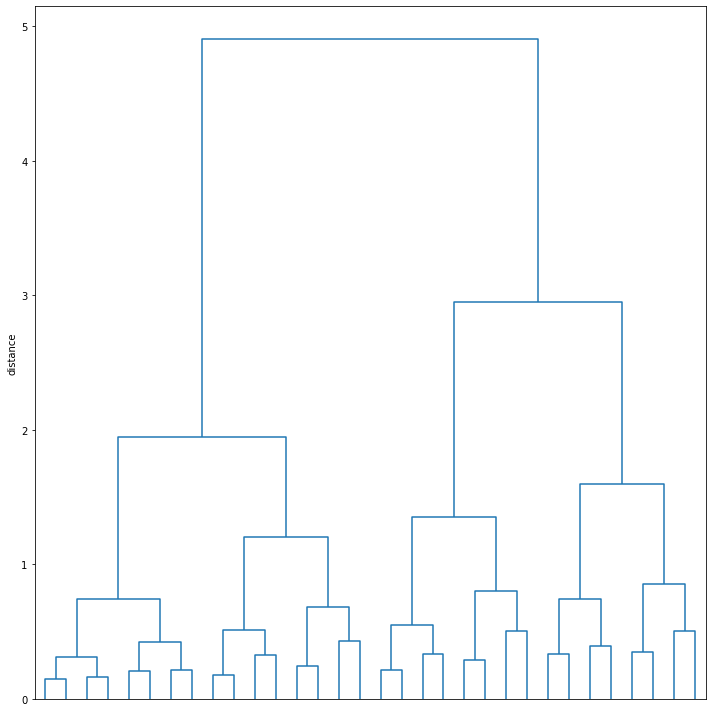

In [88]:
fig, ax = plt.subplots(figsize=(10, 10))
dendrogram(Z, labels=list(df_red.index), color_threshold=0, no_labels=True, truncate_mode='level', p=4, ax=ax)
plt.xticks(rotation=90)
ax.set_ylabel('distance')
plt.tight_layout()
plt.show()

In [89]:
memb = fcluster(Z, 3, criterion='maxclust')
memb = pd.Series(memb, index=df_red.index)
df_red["cluster"] = memb


In [90]:
df_red.loc[df_red.index, ["lat", "lon"]] = df.loc[df_red.index, ["lat", "lon"]]


In [91]:
import folium
# Centro del mapa (promedio de coordenadas)
m = folium.Map(location=[df_red['lat'].mean(), df_red['lon'].mean()], zoom_start=10)

# Paleta de colores para clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink']

for _, row in df_red.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=4,
        color=colors[int(row['cluster']) % len(colors)],
        fill=True,
        fill_opacity=0.3,  # Punto ligeramente transparente
    ).add_to(m)

m.save("mapa_clusters.html")
